# Train a BNN to classify MNIST using neural SVGD

In [1]:
# for leonhard
import os
# os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
# os.environ['XLA_FLAGS']

In [1]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 3.7e-5  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 10**2
STEP_SIZE = 1e-3 #1e-3, 1e-4 too large (w adam)
PATIENCE = 5
MAX_TRAIN_STEPS = 100 #15

Loading data...


In [2]:
%autoreload

# init particles and dynamics model

In [3]:
key, subkey = random.split(key)
init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
opt = optax.sgd(STEP_SIZE)

# opt = optax.chain(
#     optax.scale_by_adam(),
#     optax.scale(-STEP_SIZE),
# )

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               get_target_logp=bnn.get_minibatch_logp,
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[64, 64, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=True)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

In [4]:
init_particles.shape

(100, 4594)

In [5]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(mnist.training_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels)
    return loglikelihood(x) + bnn.log_prior(bnn.unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 4189019.2
hutchinson estimate: 4185536.2
ratio: 1.0008322


# train

In [6]:
# # Warmup on first batch
# NUM_WARMUP_ITER = 5
# key, subkey = random.split(key)
# neural_grad.warmup(key=subkey,
#                    sample_split_particles=sample_tv,
#                    next_data=lambda: first_batch,
#                    n_iter=NUM_WARMUP_ITER,
#                    n_inner_steps=100,
#                    progress_bar=True)

In [7]:
# fig, axs = plt.subplots(1, 3, figsize=[15, 5])

# ax = axs[0]
# ax.plot(neural_grad.rundata['training_loss'])
# ax.plot(neural_grad.rundata['validation_loss'])
# ax.axhline(y=min_loss, label="true first-batch loss", linestyle="--")

# ax = axs[1]
# ax.plot(neural_grad.rundata['training_sd'])
# ax.plot(neural_grad.rundata['validation_sd'])
# ax.axhline(y=true_sd, linestyle="--", label="true first-batch stein discrepancy")

# ax = axs[2]
# ax.plot(neural_grad.rundata['l2_norm'])
# ax.axhline(y=l2, linestyle="--", label="true l2 norm")

In [8]:
neural_grad.rundata['train_steps']

[]

In [9]:
# N_PARTICLE_STEPS = 5

key, fixed_key = random.split(key)
def step(key, train_batch):
    """one iteration of the particle trajectory simulation"""
    neural_grad.train(
        split_particles=particles.next_batch(key),
        n_steps=MAX_TRAIN_STEPS,
        data=train_batch
    )
    particles.step(neural_grad.get_params())


@jit
def compute_eval(train_batch, ps):
    test_logp = utils.vmean(bnn.get_minibatch_logp(next(mnist.test_batches)))
    train_logp = utils.vmean(bnn.get_minibatch_logp(train_batch))
    stepdata = {
        "accuracy": bnn.compute_acc_from_flat(ps),
        "test_logp": test_logp(ps),
        "training_logp": train_logp(ps),
        "particle_mean": ps.mean(),
    }
    return stepdata

In [10]:
particles.particles.shape

(100, 4594)

In [11]:
sgld = utils.sgld(5e-9)
sgld_state = sgld.init(init_particles)

@jit
def sgld_step(particles, sgld_state, images, labels):
    """Update param_set elements in parallel using Langevin dynamics."""
    def flat_loss(particle):
        return bnn.loss(bnn.unravel(particle), images, labels)

    step_losses, g = vmap(value_and_grad(flat_loss))(particles)
    g, sgld_state = sgld.update(g, sgld_state, particles)
    aux = {
        "losses": step_losses.mean(),
        "global_grad_norm": optax.global_norm(g),
    }
    particles = optax.apply_updates(particles, g)
    return particles, sgld_state, aux

In [12]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 200
sgld_aux = {}
for step_counter in tqdm(range(num_steps)):
    key, subkey = random.split(key)
    train_batch = next(mnist.training_batches)
    step(subkey, train_batch)

    # SGLD step
    particles.particles, sgld_state, aux = sgld_step(
        particles.particles, sgld_state, *train_batch)
    metrics.append_to_log(sgld_aux, aux)

    if step_counter % 10 == 0:
        metrics.append_to_log(particles.rundata,
                              compute_eval(train_batch, particles.particles))
# neural_grad.done()
# particles.done()

  6%|▌         | 11/200 [10:43<3:04:21, 58.52s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(particles.rundata['global_grad_norm_post_update'], label="NVGD update norm")
plt.plot(sgld_aux['global_grad_norm'], label="SGLD update norm")
plt.yscale('log')
plt.legend()

In [ ]:
# plt.plot(-particles.rundata['training_logp'])
# plt.plot(sgld_aux['losses']);

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])

ax = axs[0]
ax.plot(particles.rundata["accuracy"], "--.")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'], ".", label="training loss")
ax.plot(neural_grad.rundata['validation_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--")
ax.legend()

ax = axs[2]
ax.plot(particles.rundata['training_logp'])
# ax.plot(particles.rundata['test_logp'])

In [33]:
with open('nvgd.csv', "w") as f:
    f.write('step,accuracy')

In [34]:
with open('nvgd.csv', "a") as f:
    for i, a in enumerate(particles.rundata['accuracy']):
        f.write(f'{i*10},{a}\n')

In [ ]:
onp.mean(particles.rundata["accuracy"][-10:])

In [ ]:
plt.plot(neural_grad.rundata["global_gradient_norm"])

In [ ]:
particles.rundata.keys()

In [20]:
trajectories = onp.array(particles.rundata['particles'])
trajectories.shape

(11, 100, 108)

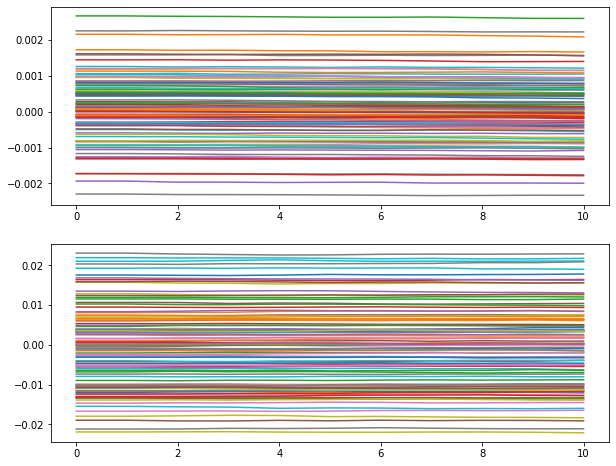

In [21]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories[:, :, 1]);  # watch single param (aka single dimension)

In [ ]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories[:, 11, :]); # watch single particle

In [ ]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])[NUM_WARMUP_ITER:]

plt.plot(neural_grad.rundata['training_loss'])
plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

In [ ]:
a = 800
b = 1000
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'][a:b], ".")
ax.plot(neural_grad.rundata['validation_loss'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2_norm'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

# particle gradient norms

In [ ]:
gs = neural_grad.grads(particles.particles)
optax.global_norm(gs)

In [ ]:
print("norm pre upate :", particles.rundata['global_grad_norm'][0])
print("norm post upate:", particles.rundata['global_grad_norm_post_update'][0])

In [ ]:
plt.plot(particles.rundata['global_grad_norm'])

In [ ]:
plt.plot(particles.rundata['global_grad_norm_post_update'])

In [ ]:
optax.global_norm(vmap(unravel)(particles.particles))

In [ ]:
jnp.sqrt(jnp.sum(particles.particles**2))

# model gradient norms

### interlude: why accuracy no change?

In [ ]:
all_preds = vmap(lambda ps: model.apply(unravel(ps), val_images[:128]).argmax(axis=1))(particles.rundata['particles'][-1])
onp.unique(all_preds, return_counts=True)

### continue with scheduled programming